In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Load resampled dataset
df = pd.read_csv("cleaned_bin_data.csv")
print(df)

       Bin_ID  latitude  longitude  Fullness        date   time day_of_week  \
0      112821   19.2183    72.9781         1  2023-07-01   9:00    Saturday   
1      112821   19.2183    72.9781         1  2023-07-01  10:00    Saturday   
2      112821   19.2183    72.9781         1  2023-07-01  11:00    Saturday   
3      112821   19.2183    72.9781         2  2023-07-01  12:00    Saturday   
4      112821   19.2183    72.9781         2  2023-07-01  13:00    Saturday   
...       ...       ...        ...       ...         ...    ...         ...   
36895  112826   19.1400    72.8600         1  2025-03-06  14:00    Thursday   
36896  112826   19.1400    72.8600         1  2025-03-06  15:00    Thursday   
36897  112826   19.1400    72.8600         2  2025-03-06  16:00    Thursday   
36898  112826   19.1400    72.8600         2  2025-03-06  17:00    Thursday   
36899  112826   19.1400    72.8600         0  2025-03-06  18:00    Thursday   

       is_holiday holiday_name  
0           False 

In [6]:
# Compute the number of time entries per day.
# This calculates the mode (most common count) of entries per day.
time_entries_per_day = df.groupby('date')['time'].nunique().mode()[0]
print("Number of time entries per day:", time_entries_per_day)

# Use this value as a default time_steps value.
# If you want to include only one day's history, use time_entries_per_day.
# Alternatively, if you want to include two days of history, you could do 2 * time_entries_per_day, etc.
time_steps = time_entries_per_day  


Number of time entries per day: 10


In [7]:
import numpy as np

def prepare_data(series, time_steps):
    """
    Prepares time series data into sequences for LSTM training.

    Args:
        series (numpy.ndarray): 1D array of values (e.g., scaled 'Fullness' values).
        time_steps (int): Number of past time steps to include in each training sample.

    Returns:
        X (numpy.ndarray): Array of input sequences with shape (num_samples, time_steps).
        y (numpy.ndarray): Array of target values with shape (num_samples,).
    """
    X, y = [], []
    for i in range(len(series) - time_steps):
        X.append(series[i:i + time_steps])
        y.append(series[i + time_steps])
    return np.array(X), np.array(y)


In [12]:
df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])

# Sort the data by the new datetime column.
df.sort_values(by='datetime', inplace=True)

# Get unique bins (if your dataset is grouped by 'Bin ID').
bins_to_forecast = df['Bin_ID'].unique()

In [13]:
train_end_date = pd.Timestamp("2025-03-05 18:00")
test_start_date = pd.Timestamp("2025-03-06 9:00")
test_end_date = test_start_date + pd.Timedelta(days=1)

In [14]:
results_sarima_lstm = {}


In [18]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
def create_model(time_steps):
    """
    Creates and compiles an LSTM model.
    
    Args:
        time_steps (int): The number of time steps in each input sequence.
        
    Returns:
        model (keras.models.Sequential): Compiled LSTM model.
    """
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(time_steps, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model
create_model(time_steps)
for bin_id in bins_to_forecast:

    # Filter data for the current bin.
    bin_data = df[df['Bin_ID'] == bin_id].copy()
    
    # Set the datetime column as index.
    bin_data.set_index('datetime', inplace=True)
    
    # Split into training and testing datasets.
    train_data = bin_data[bin_data.index <= train_end_date]
    test_data = bin_data[(bin_data.index >= test_start_date) & (bin_data.index < test_end_date)]
    
    # Use the 'Fullness' column as the target series.
    train_series = train_data['Fullness']
    
    # The number of forecast steps is the number of available time points on March 6, 2025.
    forecast_steps = len(test_data)
    
    # ----- SARIMA Model -----
    # Seasonal period is assumed to be 10 (if there are 10 entries per day); adjust if needed.
    sarima_model = SARIMAX(train_series, order=(1, 1, 1), seasonal_order=(1, 1, 1, 10))
    sarima_fit = sarima_model.fit(disp=False)
    sarima_forecast = sarima_fit.forecast(steps=forecast_steps)
    
    # ----- LSTM Model -----
    # Scale the training data.
    scaler = MinMaxScaler()
    fullness_train = scaler.fit_transform(train_series.values.reshape(-1, 1))
    
    # Define the sequence length (time_steps) for the LSTM. Adjust this parameter as needed.
    time_steps = 10
    X_train, y_train = prepare_data(fullness_train, time_steps)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    
    # Train the LSTM model.
    # NOTE: 'model' must be defined and compiled beforehand (for example, using Keras).
    model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)
    
    # Use recursive forecasting to predict the next forecast_steps values.
    predictions = []
    last_sequence = fullness_train[-time_steps:].reshape(1, time_steps, 1)
    for _ in range(forecast_steps):
        pred = model.predict(last_sequence, verbose=0)
        predictions.append(pred[0, 0])
        # Update the sequence by removing the first value and appending the new prediction.
        last_sequence = np.append(last_sequence[:, 1:, :], [[[pred[0, 0]]]], axis=1)
    
    # Inverse transform the LSTM predictions back to the original scale.
    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    
    # ----- Hybrid Forecast -----
    # Compute the hybrid forecast as the average of the SARIMA and LSTM predictions.
    hybrid_forecast = (sarima_forecast.values.reshape(-1, 1) + predictions) / 2
    
    # ----- Plotting -----
    plt.figure(figsize=(12, 6))
    plt.plot(test_data.index, test_data['Fullness'], 'bo-', label="Actual Fullness", linewidth=2)
    plt.plot(test_data.index, hybrid_forecast, 'ro--', label="Hybrid SARIMA + LSTM", linewidth=2)
    plt.title(f"Hybrid Forecast for Bin {bin_id} on 6th March 2025")
    plt.xlabel("Datetime")
    plt.ylabel("Fullness Level")
    plt.legend()
    plt.grid()
    plt.show()
    
    # ----- RMSE Calculation -----
    rmse = np.sqrt(mean_squared_error(test_data['Fullness'].values.reshape(-1, 1), hybrid_forecast))
    results_sarima_lstm[bin_id] = rmse

c:\Users\dhyey\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\dhyey\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dhyey\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dhyey\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978:

NameError: name 'model' is not defined

c:\Users\dhyey\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dhyey\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dhyey\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\dhyey\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction 

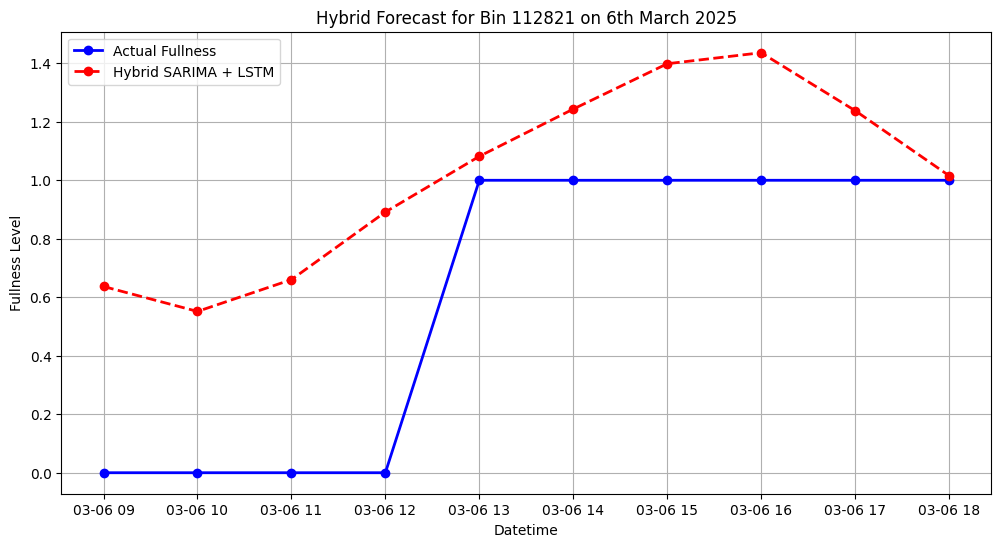

c:\Users\dhyey\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dhyey\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dhyey\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\dhyey\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction 

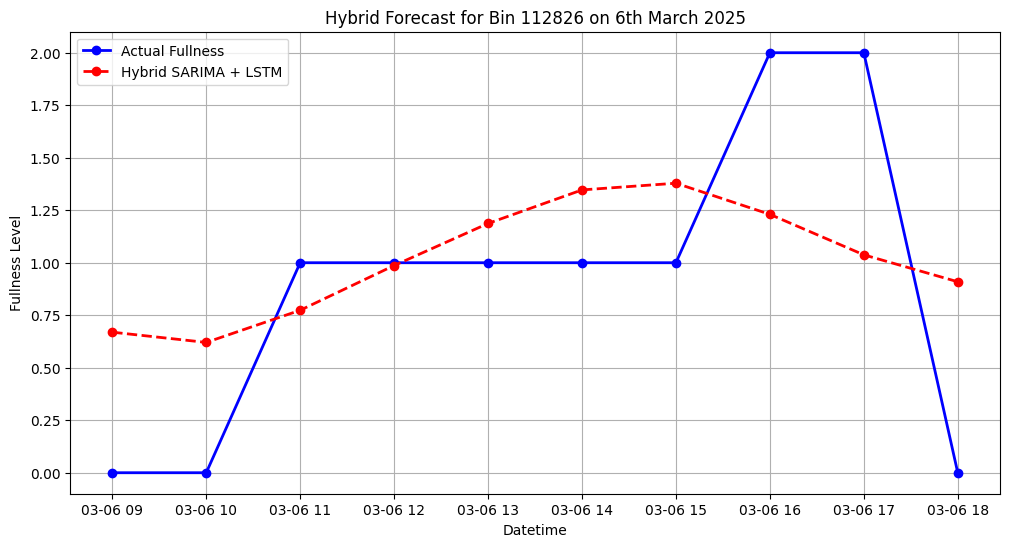

c:\Users\dhyey\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dhyey\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dhyey\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\dhyey\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction 

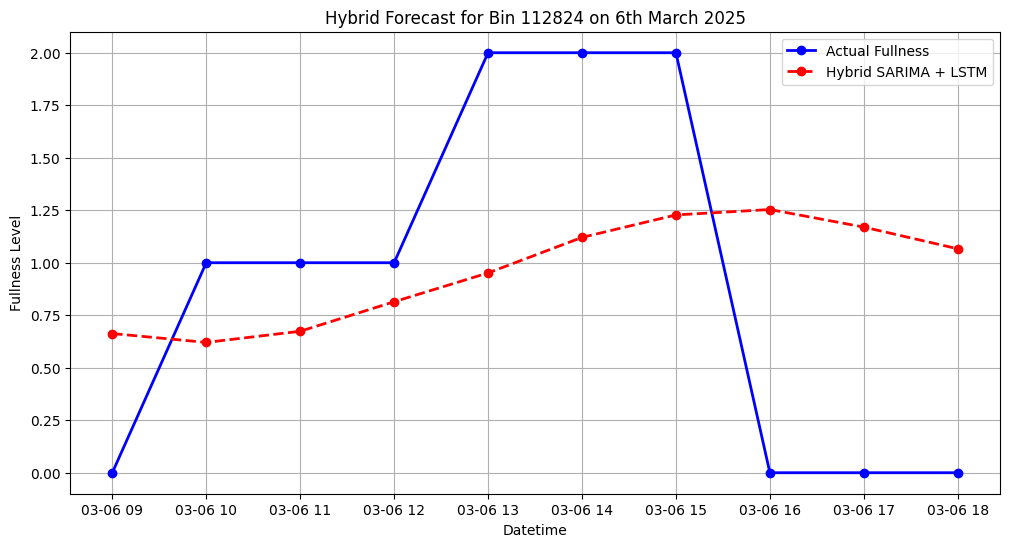

c:\Users\dhyey\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dhyey\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dhyey\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\dhyey\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction 

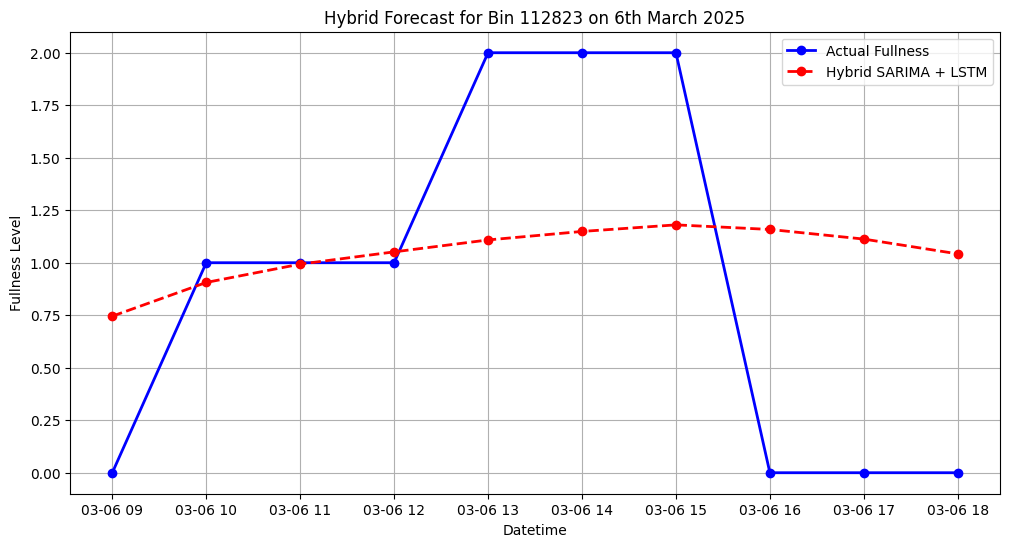

c:\Users\dhyey\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dhyey\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dhyey\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\dhyey\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction 

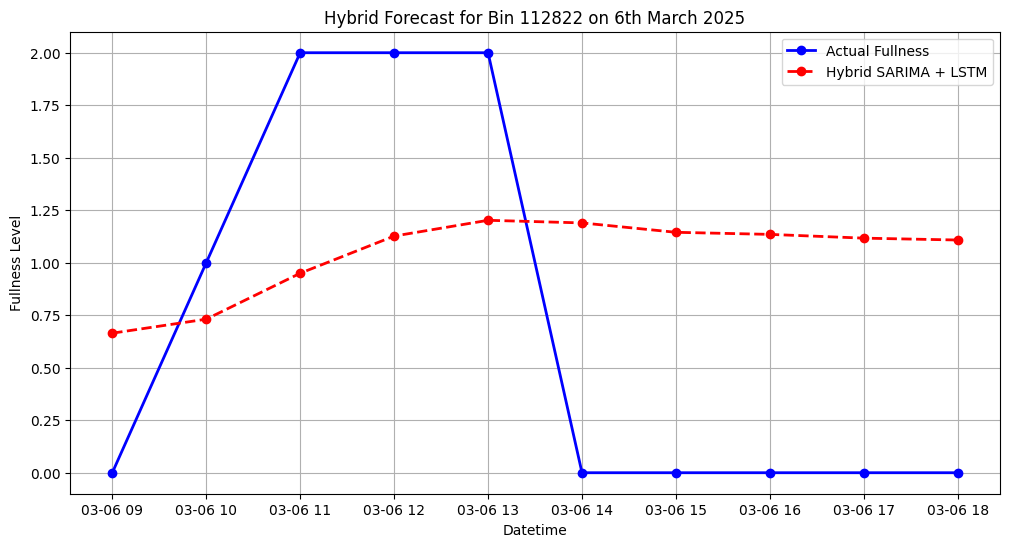

c:\Users\dhyey\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dhyey\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dhyey\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\dhyey\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction 

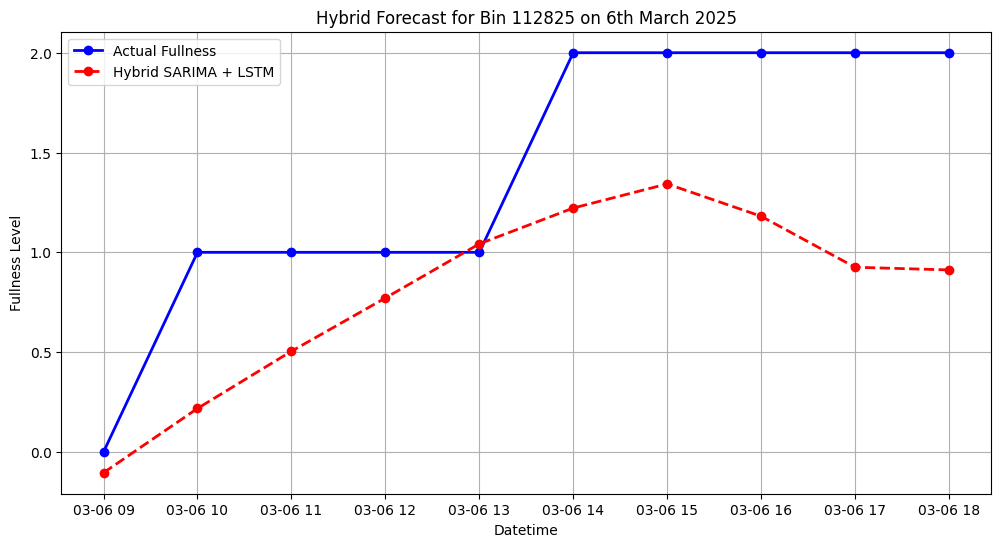

        Hybrid SARIMA + LSTM RMSE
Bin_ID                           
112821                   0.491150
112826                   0.594001
112824                   0.852658
112823                   0.801518
112822                   0.974957
112825                   0.705076


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense

# ----- Helper Function to Prepare Data for LSTM -----
def prepare_data(series, time_steps):
    """
    Converts a 1D numpy array into sequences of length `time_steps`.
    
    Args:
        series (numpy.ndarray): 1D array of values (e.g., scaled Fullness values).
        time_steps (int): Number of past time steps to include for prediction.
        
    Returns:
        X (numpy.ndarray): Input sequences with shape (num_samples, time_steps).
        y (numpy.ndarray): Target values with shape (num_samples,).
    """
    X, y = [], []
    for i in range(len(series) - time_steps):
        X.append(series[i:i + time_steps])
        y.append(series[i + time_steps])
    return np.array(X), np.array(y)

# ----- Helper Function to Create an LSTM Model -----
def create_model(time_steps):
    """
    Creates and compiles an LSTM model.
    
    Args:
        time_steps (int): The number of time steps in each input sequence.
        
    Returns:
        model (keras.models.Sequential): Compiled LSTM model.
    """
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(time_steps, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# ----- Read and Preprocess the CSV Data -----
# The CSV should have columns: 'Bin_ID', 'date', 'time', 'Fullness'
df = pd.read_csv("cleaned_bin_data.csv")

# Combine the 'date' and 'time' columns into a single datetime column.
df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])
df.sort_values(by='datetime', inplace=True)

# Define training and testing boundaries.
train_end_date = pd.Timestamp("2025-03-05 23:59:59")
test_start_date = pd.Timestamp("2025-03-06 00:00:00")
test_end_date = pd.Timestamp("2025-03-07 00:00:00")

# Get unique bin identifiers.
bins_to_forecast = df['Bin_ID'].unique()

results_sarima_lstm = {}

# ----- Loop Through Each Bin and Forecast -----
for bin_id in bins_to_forecast:
    # Filter data for the current bin.
    bin_data = df[df['Bin_ID'] == bin_id].copy()
    
    # Set the datetime column as the index.
    bin_data.set_index('datetime', inplace=True)
    
    # Split data into training (up to March 5, 2025) and testing (March 6, 2025).
    train_data = bin_data[bin_data.index <= train_end_date]
    test_data = bin_data[(bin_data.index >= test_start_date) & (bin_data.index < test_end_date)]
    
    # Use the 'Fullness' column as the target series.
    train_series = train_data['Fullness']
    
    # Number of forecast steps equals the number of available time points on March 6, 2025.
    forecast_steps = len(test_data)
    
    # ----- SARIMA Model Forecasting -----
    # Seasonal period is assumed to be 10 (if there are 10 entries per day); adjust if necessary.
    sarima_model = SARIMAX(train_series, order=(1, 1, 1), seasonal_order=(1, 1, 1, 10))
    sarima_fit = sarima_model.fit(disp=False)
    sarima_forecast = sarima_fit.forecast(steps=forecast_steps)
    
    # ----- LSTM Model Forecasting -----
    # Scale the training series.
    scaler = MinMaxScaler()
    fullness_train = scaler.fit_transform(train_series.values.reshape(-1, 1))
    
    # Define the sequence length (time_steps) for the LSTM.
    # Here we assume there are 10 entries per day.
    time_steps = 10
    
    # Prepare data sequences for LSTM.
    X_train, y_train = prepare_data(fullness_train, time_steps)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    
    # Create and train the LSTM model.
    model = create_model(time_steps)
    model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)
    
    # Use recursive forecasting to predict the next forecast_steps values.
    predictions = []
    last_sequence = fullness_train[-time_steps:].reshape(1, time_steps, 1)
    for _ in range(forecast_steps):
        pred = model.predict(last_sequence, verbose=0)
        predictions.append(pred[0, 0])
        # Update the sequence by removing the first value and appending the new prediction.
        last_sequence = np.append(last_sequence[:, 1:, :], [[[pred[0, 0]]]], axis=1)
    
    # Convert LSTM predictions back to the original scale.
    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    
    # ----- Hybrid Forecast -----
    # Compute the hybrid forecast as the average of the SARIMA and LSTM predictions.
    hybrid_forecast = (sarima_forecast.values.reshape(-1, 1) + predictions) / 2
    
    # ----- Plotting -----
    plt.figure(figsize=(12, 6))
    plt.plot(test_data.index, test_data['Fullness'], 'bo-', label="Actual Fullness", linewidth=2)
    plt.plot(test_data.index, hybrid_forecast, 'ro--', label="Hybrid SARIMA + LSTM", linewidth=2)
    plt.title(f"Hybrid Forecast for Bin {bin_id} on 6th March 2025")
    plt.xlabel("Datetime")
    plt.ylabel("Fullness Level")
    plt.legend()
    plt.grid()
    plt.show()
    
    # ----- RMSE Calculation -----
    rmse = np.sqrt(mean_squared_error(test_data['Fullness'].values.reshape(-1, 1), hybrid_forecast))
    results_sarima_lstm[bin_id] = rmse

# Display RMSE for each bin.
rmse_df = pd.DataFrame.from_dict(results_sarima_lstm, orient='index', 
                                 columns=['Hybrid SARIMA + LSTM RMSE'])
rmse_df.index.name = "Bin_ID"
print(rmse_df)
